In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import sys
from kats.consts import TimeSeriesData


In [2]:
air_passengers_df = pd.read_csv("../data/air_passengers.csv")

In [3]:
air_passengers_df.columns = ["time", "value"]
air_passengers_df.head()

,time,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [4]:
multi_ts_df = pd.read_csv("../data/multi_ts.csv", index_col=0)

In [5]:
multi_ts_df.columns = ["time", "v1", "v2"]
multi_ts_df.head()


,time,v1,v2
0,2017-03-12,-0.109,53.8
1,2017-03-13,0.000,53.6
2,2017-03-14,0.178,53.5
3,2017-03-15,0.339,53.5
4,2017-03-16,0.373,53.4


In [6]:
air_passengers_ts = TimeSeriesData(air_passengers_df)
multi_ts = TimeSeriesData(multi_ts_df)

In [7]:
print(type(air_passengers_ts))
print(type(multi_ts))

<class 'kats.consts.TimeSeriesData'>
<class 'kats.consts.TimeSeriesData'>


In [8]:
air_passengers_ts[1:5] #slice


,time,value
0,1949-02-01,118
1,1949-03-01,132
2,1949-04-01,129
3,1949-05-01,121


In [9]:
ts_1 = air_passengers_ts[0:3]
ts_2 = air_passengers_ts[3:7]

ts_1.extend(ts_2) #extend
len(ts_1)

7

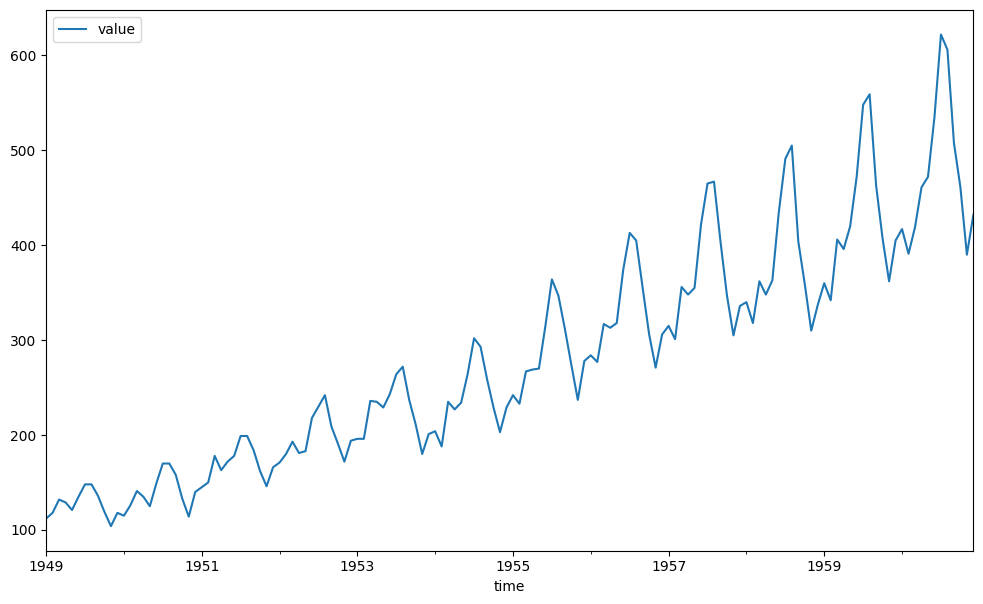

In [10]:
%matplotlib inline

# Must pass the name of the value columns to plot
air_passengers_ts.plot(cols=['value'])
plt.show()

In [11]:
len(multi_ts)
multi_ts = TimeSeriesData(multi_ts_df)

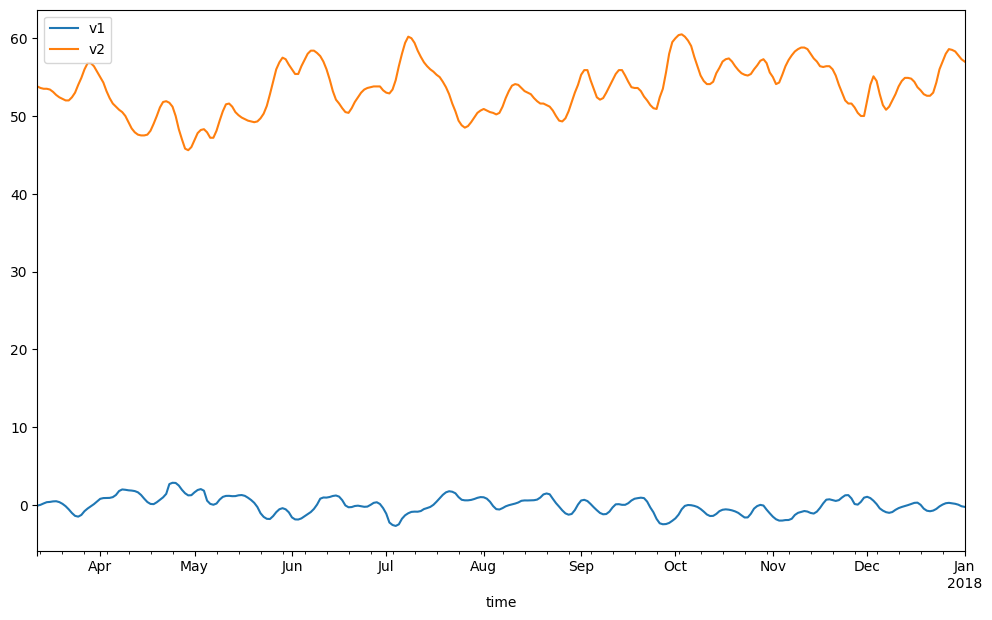

In [12]:
%matplotlib inline

multi_ts.plot(cols=["v1","v2"])
plt.show()

In [13]:
air_passengers_ts.is_univariate() 

True

In [14]:
multi_ts.is_univariate()

False

In [15]:
# import the param and model classes for Prophet model
from kats.models.prophet import ProphetModel, ProphetParams

# create a model param instance
params = ProphetParams(seasonality_mode='multiplicative') # additive mode gives worse results

# create a prophet model instance
m = ProphetModel(air_passengers_ts, params)

# fit model simply by calling m.fit()
m.fit()

# make prediction for next 30 month
fcst = m.predict(steps=30, freq="MS")

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.46502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       501.164    0.00404329       133.096      0.7795      0.7795      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       503.029    0.00011625       61.0812      0.7463      0.7463      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       503.241   0.000197464       74.1894      0.6815      0.6815      384   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     376       503.429   0.000269211       170.518   3.444e-06       0.001      512  LS failed, Hessian reset 
     399       503.521    0.00012352       74.8921      0.4361      0.4361      542   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     428       503.524   4.87946e-06    

<AxesSubplot: xlabel='time', ylabel='y'>

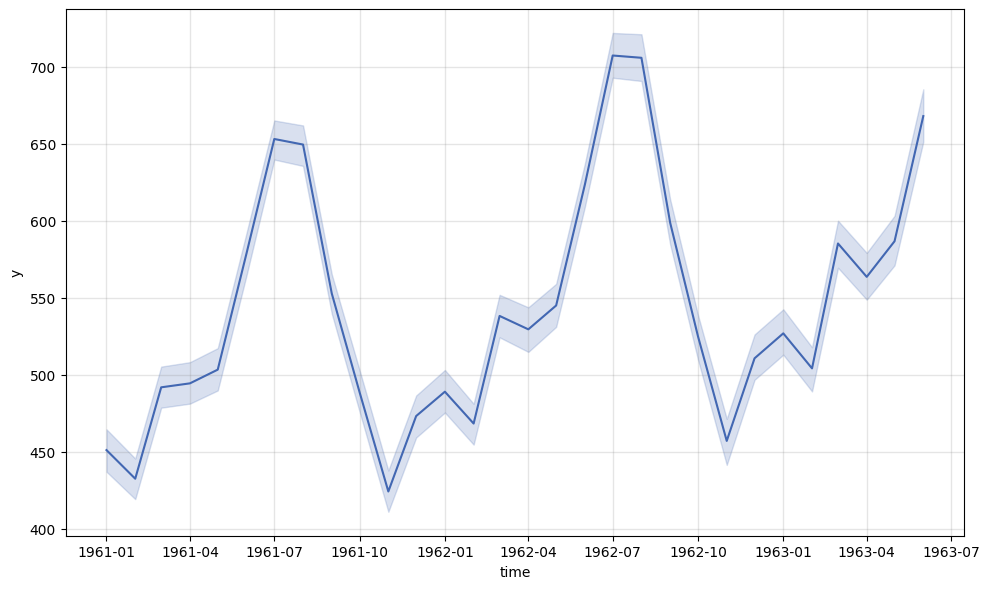

In [16]:
# visualize the results with uncertainty intervals
m.plot()

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning:

After 0.13 initialization must be handled at model creation

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/kats/models/theta.py:130: FutureWarning:

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.



<AxesSubplot: xlabel='time', ylabel='y'>

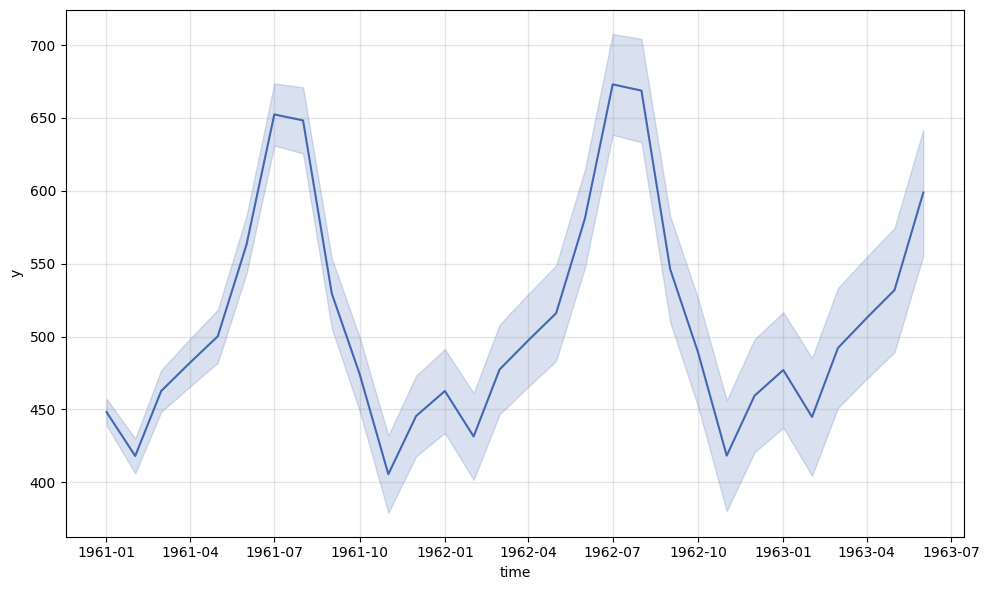

In [17]:
# import param and model from `kats.models.theta`
from kats.models.theta import ThetaModel, ThetaParams

params = ThetaParams(m=12) # why does m = 12

m = ThetaModel(data=air_passengers_ts, params=params)
# call fit method to fit model
m.fit()
# call predict method to predict the next 30 steps
res = m.predict(steps=30, alpha=0.2)
# visualize the results
m.plot()

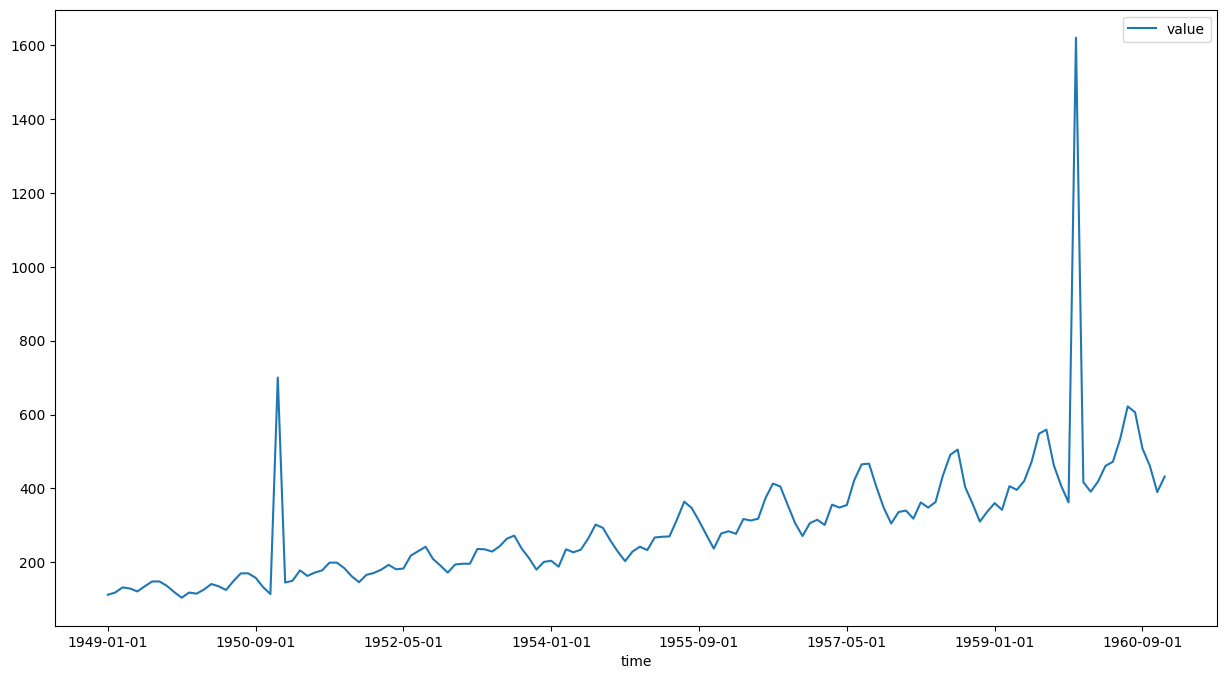

In [18]:
air_passengers_outlier_df = air_passengers_df.copy(deep=True)

# manually add outlier on the date of '1950-12-01'
air_passengers_outlier_df.loc[air_passengers_outlier_df.time == '1950-12-01','value']*=5
# manually add outlier on the date of '1959-12-01'
air_passengers_outlier_df.loc[air_passengers_outlier_df.time == '1959-12-01', 'value']*=4

# visualize the raw data
air_passengers_outlier_df.plot(x='time', y='value', figsize=(15,8))
plt.show()



In [19]:
air_passengers_outlier_ts = TimeSeriesData(air_passengers_outlier_df)

from kats.detectors.outlier import OutlierDetector

ts_outlierDetection = OutlierDetector(air_passengers_outlier_ts, 'additive') # call OutlierDetector
ts_outlierDetection.detector() # apply OutlierDetector

# Here we look at the outliers that the algorithm found.

ts_outlierDetection.outliers[0]



[Timestamp('1950-12-01 00:00:00'),
 Timestamp('1959-11-01 00:00:00'),
 Timestamp('1959-12-01 00:00:00'),
 Timestamp('1960-11-01 00:00:00'),
 Timestamp('1960-12-01 00:00:00')]

In [20]:
air_passengers_ts_outliers_removed = ts_outlierDetection.remover(interpolate = False) # No interpolation
air_passengers_ts_outliers_interpolated = ts_outlierDetection.remover(interpolate = True) # With interpolation


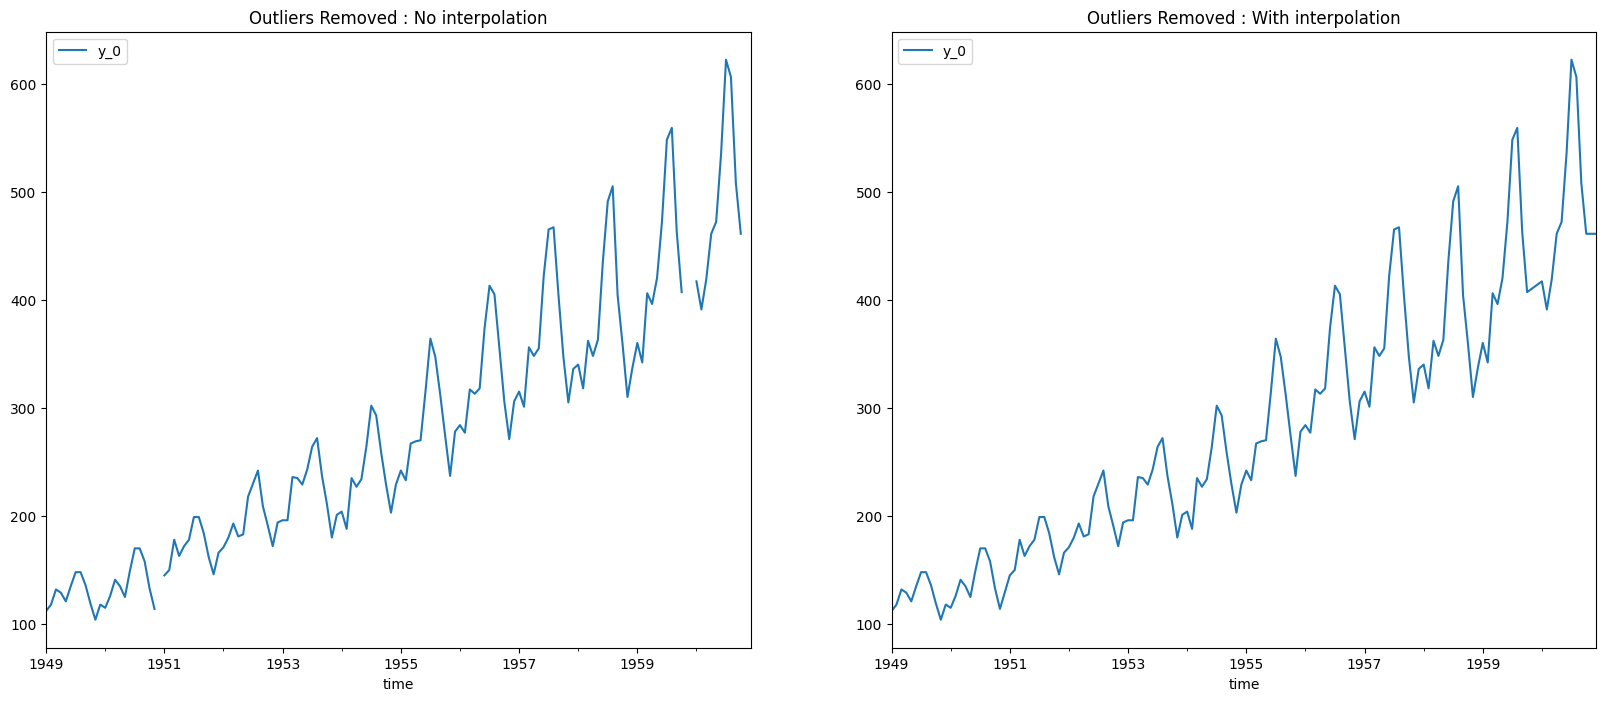

In [21]:
fig, ax = plt.subplots(figsize=(20,8), nrows=1, ncols=2)

air_passengers_ts_outliers_removed.to_dataframe().plot(x = 'time',y = 'y_0', ax= ax[0])
ax[0].set_title("Outliers Removed : No interpolation")
air_passengers_ts_outliers_interpolated.to_dataframe().plot(x = 'time',y = 'y_0', ax= ax[1])
ax[1].set_title("Outliers Removed : With interpolation")
plt.show()

In [22]:
# Initiate feature extraction class
from kats.tsfeatures.tsfeatures import TsFeatures
tsFeatures = TsFeatures()

features_air_passengers = TsFeatures().transform(air_passengers_ts)



In [23]:
features_air_passengers
from kats.models.metalearner.get_metadata import GetMetaData

# create an object MD of class GetMetaData with error method mean absolute percentage error (mape)
MD = GetMetaData(data=air_passengers_ts, error_method='mape')

In [25]:
# code ~/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/botorch/models/utils.py

air_passengers_metadata = MD.get_meta_data()

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "p". Defaulting to `True` for parameters of `ParameterType` INT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "d". Defaulting to `True` for parameters of `ParameterType` INT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "q". Defaulting to `True` for parameters of `Paramete

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.87877D+00    |proj g|=  3.85382D+01

At iterate    5    f= -1.88910D+00    |proj g|=  8.66498D-02

At iterate   10    f= -1.88912D+00    |proj g|=  1.70444D+00

At iterate   15    f= -1.88941D+00    |proj g|=  3.67829D-01

At iterate   20    f= -1.88941D+00    |proj g|=  2.86047D-02

At iterate   25    f= -1.88941D+00    |proj g|=  4.62892D-01

At iterate   30    f= -1.88946D+00    |proj g|=  2.41960D-02

At iterate   35    f= -1.88947D+00    |proj g|=  1.78906D-03

At iterate   40    f= -1.88947D+00    |proj g|=  3.26474D-02

At iterate   45    f= -1.88947D+00    |proj g|=  2.73411D-01

At iterate   50    f= -1.88947D+00    |proj g|=  1.55079D-02

At iterate   55    f= -1.88947D+00    |proj g|=  1.92608D-03

At iterate   60    f= -1.88947D+00    |proj g|=  5.63993D-06

           * * *

Tit   = 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


/Users/ondrejik/Library/Caches/pypoetry/virtual

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.79622D+00    |proj g|=  7.69387D+01

At iterate    5    f= -1.80490D+00    |proj g|=  3.26145D-02

At iterate   10    f= -1.80490D+00    |proj g|=  6.16465D-01

At iterate   15    f= -1.80497D+00    |proj g|=  5.81208D+00

At iterate   20    f= -1.80515D+00    |proj g|=  6.85521D-03

At iterate   25    f= -1.80526D+00    |proj g|=  1.08705D+00

At iterate   30    f= -1.80527D+00    |proj g|=  5.83067D-03

At iterate   35    f= -1.80527D+00    |proj g|=  9.21011D-02

At iterate   40    f= -1.80542D+00    |proj g|=  4.82180D+00

At iterate   45    f= -1.80551D+00    |proj g|=  3.08862D-03

At iterate   50    f= -1.80551D+00    |proj g|=  8.16007D-02

At iterate   55    f= -1.80552D+00    |proj g|=  1.96845D-01

At iterate   60    f= -1.80565D+00    |proj g|=  1.27397D+00

At iterate   65    f= -1.8

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.99869D+00    |proj g|=  7.92735D+00

At iterate    5    f= -1.99962D+00    |proj g|=  2.98716D-01

At iterate   10    f= -1.99984D+00    |proj g|=  2.93281D+00

At iterate   15    f= -2.00010D+00    |proj g|=  1.98986D-02

At iterate   20    f= -2.00062D+00    |proj g|=  1.23815D+00

At iterate   25    f= -2.00211D+00    |proj g|=  2.50028D-01

At iterate   30    f= -2.00387D+00    |proj g|=  1.35962D-01

At iterate   35    f= -2.00387D+00    |proj g|=  4.40987D-01

At iterate   40    f= -2.00445D+00    |proj g|=  4.54633D+00

At iterate   45    f= -2.00653D+00    |proj g|=  1.21537D+00

At iterate   50    f= -2.00692D+00    |proj g|=  3.06203D-02

At iterate   55    f= -2.00692D+00    |proj g|=  5.44800D-02

At iterate   60    f= -2.00695D+00    |proj g|=  8.35539D-01

At iterate   65    f= -2.0


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.ts

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.82882D+00    |proj g|=  1.10957D+00

At iterate    5    f= -1.82933D+00    |proj g|=  7.66768D-01

At iterate   10    f= -1.83075D+00    |proj g|=  4.96483D-02

At iterate   15    f= -1.83075D+00    |proj g|=  3.49230D-03

At iterate   20    f= -1.83075D+00    |proj g|=  3.87758D-02

At iterate   25    f= -1.83076D+00    |proj g|=  7.78400D-04

At iterate   30    f= -1.83076D+00    |proj g|=  8.05245D-03

At iterate   35    f= -1.83076D+00    |proj g|=  2.32263D-03

At iterate   40    f= -1.83078D+00    |proj g|=  7.97629D-03

At iterate   45    f= -1.83079D+00    |proj g|=  1.58895D-04


 This problem is unconstrained.



At iterate   50    f= -1.83079D+00    |proj g|=  3.67262D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     51     70      1     0     0   3.793D-05  -1.831D+00
  F =  -1.8307922233603624     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.80205D+00    |proj g|=  1.81811D+01

At iterate    5    f= -1.80245D+00    |proj g|=  6.56462D-01

At iterate   10    f= -1.80256D+00    |proj g|=  8.46113D+00


/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.


At iterate   15    f= -1.80296D+00    |proj g|=  9.39455D-03

At iterate   20    f= -1.80299D+00    |proj g|=  2.11336D+00

At iterate   25    f= -1.80481D+00    |proj g|=  1.21183D+01

At iterate   30    f= -1.80571D+00    |proj g|=  8.31108D-02

At iterate   35    f= -1.80571D+00    |proj g|=  3.67470D-01

At iterate   40    f= -1.80571D+00    |proj g|=  9.98979D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     57      1     0     0   9.990D-05  -1.806D+00
  F =  -1.8057118040333278     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.86595D+00    |proj g|=  1.93826D+01

At iterate    5    f= -1.86686D+00    |proj g|=  3.50255D+00

At iterate   10    f= -1.87208D+00    |proj g|=  4.10238D+01

At iterate   15    f= -1.87774D+00    |proj g|=  9.91006D-02

At iterate   20    f= -1.87777D+00    |proj g|=  9.05546D-01

At iterate   25    f= -1.88053D+00    |proj g|=  1.11955D+01

At iterate   30    f= -1.89124D+00    |proj g|=  1.91937D+01

At iterate   35    f= -1.89142D+00    |proj g|=  1.01730D+00

At iterate   40    f= -1.89268D+00    |proj g|=  9.25957D+01

At iterate   45    f= -1.90178D+00    |proj g|=  6.77510D+00

At iterate   50    f= -1.90178D+00    |proj g|=  3.67497D-02

At iterate   55    f= -1.90178D+00    |proj g|=  2.69507D-02

At iterate   60    f= -1.90178D+00    |proj g|=  7.31172D-01

At iterate   65    f= -1.9


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.ts

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.87687D+00    |proj g|=  4.03373D+00

At iterate    5    f= -1.87690D+00    |proj g|=  9.45460D-01

At iterate   10    f= -1.87724D+00    |proj g|=  1.38355D+01

At iterate   15    f= -1.87969D+00    |proj g|=  1.10272D-01

At iterate   20    f= -1.87981D+00    |proj g|=  6.30605D-01

At iterate   25    f= -1.88046D+00    |proj g|=  7.81511D-02


 This problem is unconstrained.



At iterate   30    f= -1.88152D+00    |proj g|=  6.66729D-03

At iterate   35    f= -1.88152D+00    |proj g|=  4.12289D-01

At iterate   40    f= -1.88157D+00    |proj g|=  4.80405D+00

At iterate   45    f= -1.88253D+00    |proj g|=  4.54644D+00

At iterate   50    f= -1.88262D+00    |proj g|=  2.44783D-02

At iterate   55    f= -1.88262D+00    |proj g|=  2.81225D-02

At iterate   60    f= -1.88262D+00    |proj g|=  1.40378D-01

At iterate   65    f= -1.88262D+00    |proj g|=  5.37739D-03

At iterate   70    f= -1.88262D+00    |proj g|=  2.42584D-01

At iterate   75    f= -1.88273D+00    |proj g|=  1.27127D+00

At iterate   80    f= -1.88370D+00    |proj g|=  3.09217D-01

At iterate   85    f= -1.88371D+00    |proj g|=  1.31686D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized 

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.91997D+00    |proj g|=  2.46072D+00

At iterate    5    f= -1.92001D+00    |proj g|=  8.11585D-02

At iterate   10    f= -1.92002D+00    |proj g|=  1.19579D+00

At iterate   15    f= -1.92015D+00    |proj g|=  4.56136D-01

At iterate   20    f= -1.92015D+00    |proj g|=  1.18289D-02

At iterate   25    f= -1.92016D+00    |proj g|=  2.45427D-01

At iterate   30    f= -1.92021D+00    |proj g|=  2.20371D-01

At iterate   35    f= -1.92021D+00    |proj g|=  5.50684D-03

At iterate   40    f= -1.92024D+00    |proj g|=  9.29665D-03

At iterate   45    f= -1.92024D+00    |proj g|=  2.37779D-03

At iterate   50    f= -1.92025D+00    |proj g|=  1.26270D-01

At iterate   55    f= -1.92031D+00    |proj g|=  2.16501D-01

At iterate   60    f= -1.92031D+00    |proj g|=  3.00422D-03

At iterate   65    f= -1.9

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.97660D+00    |proj g|=  3.53061D+01

At iterate    5    f= -1.98468D+00    |proj g|=  5.64069D-01

At iterate   10    f= -1.98511D+00    |proj g|=  6.21656D+00

At iterate   15    f= -1.98570D+00    |proj g|=  4.82512D-02

At iterate   20    f= -1.98597D+00    |proj g|=  8.60829D-01

At iterate   25    f= -1.98924D+00    |proj g|=  8.73258D-01

At iterate   30    f= -1.99596D+00    |proj g|=  2.67003D+00

At iterate   35    f= -1.99754D+00    |proj g|=  9.76571D-01

At iterate   40    f= -1.99949D+00    |proj g|=  6.14764D-02

At iterate   45    f= -2.00078D+00    |proj g|=  5.54382D-02

At iterate   50    f= -2.00228D+00    |proj g|=  3.38707D-01

At iterate   55    f= -2.01480D+00    |proj g|=  1.42163D-01


/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning:

overflow encountered in exp

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning:

invalid value encountered in true_divide

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning:

overflow encountered in exp

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning:

invalid value encountered in true_divide


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   60    f= -2.01480D+00    |proj g|=  7.79829D-01

At iterate   65    f= -2.01511D+00    |proj g|=  5.47808D+00

At iterate   70    f= -2.01534D+00    |proj g|=  5.41437D-02

At iterate   75    f= -2.01719D+00    |proj g|=  4.21894D-02

At iterate   80    f= -2.01721D+00    |proj g|=  9.30193D-01

At iterate   85    f= -2.01752D+00    |proj g|=  8.18767D-01

At iterate   90    f= -2.01753D+00    |proj g|=  8.96043D-03

At iterate   95    f= -2.01755D+00    |proj g|=  4.18864D-01

At iterate  100    f= -2.01832D+00    |proj g|=  2.00726D+00

At iterate  105    f= -2.01873D+00    |proj g|=  5.83078D-02

At iterate  110    f= -2.01878D+00    |proj g|=  5.23959D-01

At iterate  115    f= -2.01901D+00    |proj g|=  1.99432D-01

At iterate  120    f= -2.01905D+00    |proj g|=  7.26392D-03

At iterate  125    f= -2.01907D+00    |proj g|=  2.97119D-01

At iterate  130    f= -2.01940D+00    |proj g|=  3.69017D-01

At iterate  135    f= -2.01942D+00    |proj g|=  1.44689D-01

At iter

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.76275D+00    |proj g|=  8.07468D+01

At iterate    5    f= -1.76868D+00    |proj g|=  6.36423D-02

At iterate   10    f= -1.76868D+00    |proj g|=  1.17223D+00

At iterate   15    f= -1.76883D+00    |proj g|=  1.14006D+01

At iterate   20    f= -1.76941D+00    |proj g|=  4.98468D-02

At iterate   25    f= -1.76941D+00    |proj g|=  1.44938D-02

At iterate   30    f= -1.76941D+00    |proj g|=  2.18956D-01

At iterate   35    f= -1.76941D+00    |proj g|=  1.43069D+00

At iterate   40    f= -1.76942D+00    |proj g|=  1.80276D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.92623D+00    |proj g|=  3.54501D-01

At iterate    5    f= -1.93480D+00    |proj g|=  1.08433D+00

At iterate   10    f= -1.93842D+00    |proj g|=  1.79786D-01

At iterate   15    f= -1.94154D+00    |proj g|=  7.62116D-02

At iterate   20    f= -1.94205D+00    |proj g|=  5.87295D-02

At iterate   25    f= -1.94244D+00    |proj g|=  6.52936D-02


 This problem is unconstrained.



At iterate   30    f= -1.94582D+00    |proj g|=  8.27725D-02

At iterate   35    f= -1.94605D+00    |proj g|=  7.79048D-03

At iterate   40    f= -1.94622D+00    |proj g|=  4.49175D-02

At iterate   45    f= -1.94628D+00    |proj g|=  8.06968D-03

At iterate   50    f= -1.94628D+00    |proj g|=  5.49338D-05

At iterate   55    f= -1.94628D+00    |proj g|=  4.96714D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     57     87      1     0     0   1.612D-05  -1.946D+00
  F =  -1.9462762617118297     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.87634D+00    |proj g|=  2.99227D+00

At iterate    5    f= -1.87635D+00    |proj g|=  1.23040D+00

At iterate   10    f= -1.87686D+00    |proj g|=  1.66841D+01

At iterate   15    f= -1.88199D+00    |proj g|=  1.46238D-01

At iterate   20    f= -1.88248D+00    |proj g|=  5.34549D+00

At iterate   25    f= -1.88301D+00    |proj g|=  1.20989D-01

At iterate   30    f= -1.88312D+00    |proj g|=  3.21386D+00

At iterate   35    f= -1.88566D+00    |proj g|=  5.09818D+00

At iterate   40    f= -1.88574D+00    |proj g|=  1.30406D-02

At iterate   45    f= -1.88589D+00    |proj g|=  1.12721D+00

At iterate   50    f= -1.88874D+00    |proj g|=  2.41626D-02

At iterate   55    f= -1.88882D+00    |proj g|=  1.18919D-02

At iterate   60    f= -1.88884D+00    |proj g|=  2.33211D-01

At iterate   65    f= -1.8

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.79947D+00    |proj g|=  5.73252D+01

At iterate    5    f= -1.80274D+00    |proj g|=  5.10944D-01

At iterate   10    f= -1.80279D+00    |proj g|=  6.98340D+00

At iterate   15    f= -1.80373D+00    |proj g|=  3.65332D+00

At iterate   20    f= -1.80377D+00    |proj g|=  2.19253D+00

At iterate   25    f= -1.80908D+00    |proj g|=  4.48318D+01

At iterate   30    f= -1.81167D+00    |proj g|=  7.07644D-02

At iterate   35    f= -1.81592D+00    |proj g|=  2.53837D+00

At iterate   40    f= -1.81595D+00    |proj g|=  1.11549D-03

At iterate   45    f= -1.81595D+00    |proj g|=  4.03844D-02

At iterate   50    f= -1.81595D+00    |proj g|=  5.11854D-01

At iterate   55    f= -1.81597D+00    |proj g|=  1.66534D-01

At iterate   60    f= -1.81635D+00    |proj g|=  1.99211D+00

At iterate   65    f= -1.8

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


At iterate   25    f= -1.76967D+00    |proj g|=  1.75906D-02

At iterate   30    f= -1.76967D+00    |proj g|=  2.38240D-01

At iterate   35    f= -1.76967D+00    |proj g|=  5.88131D-01

At iterate   40    f= -1.76967D+00    |proj g|=  9.72333D-05

At iterate   45    f= -1.76967D+00    |proj g|=  4.68756D-03

At iterate   50    f= -1.76967D+00    |proj g|=  1.35003D-02

At iterate   55    f= -1.76967D+00    |proj g|=  2.19824D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     57     70      1     0     0   8.304D-06  -1.770D+00
  F =  -1.7696682911272412     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.80372D+00    |proj g|=  5.47986D+01

At iterate    5    f= -1.80748D+00    |proj g|=  1.32764D-01

At iterate   10    f= -1.80749D+00    |proj g|=  1.93762D+00

At iterate   15    f= -1.80792D+00    |proj g|=  1.48636D+01

At iterate   20    f= -1.80853D+00    |proj g|=  1.73690D-02

At iterate   25    f= -1.80855D+00    |proj g|=  1.53604D+00

At iterate   30    f= -1.80926D+00    |proj g|=  6.58924D+00

At iterate   35    f= -1.80947D+00    |proj g|=  8.76124D-03

At iterate   40    f= -1.80948D+00    |proj g|=  3.79788D-01

At iterate   45    f= -1.81002D+00    |proj g|=  9.14012D+00

At iterate   50    f= -1.81093D+00    |proj g|=  8.84566D-02

At iterate   55    f= -1.81133D+00    |proj g|=  2.91681D+00

At iterate   60    f= -1.81310D+00    |proj g|=  3.30888D+00

At iterate   65    f= -1.8


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


/Users/ondrejik/Library/Caches/pypoetry/virtual

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.99865D+00    |proj g|=  8.06353D+00

At iterate    5    f= -1.99961D+00    |proj g|=  5.32012D-01

At iterate   10    f= -2.00001D+00    |proj g|=  2.32804D+00

At iterate   15    f= -2.00018D+00    |proj g|=  1.74226D-01

At iterate   20    f= -2.00410D+00    |proj g|=  4.84608D-01


 This problem is unconstrained.



At iterate   25    f= -2.00422D+00    |proj g|=  9.60379D-01

At iterate   30    f= -2.00611D+00    |proj g|=  4.28632D-01

At iterate   35    f= -2.00613D+00    |proj g|=  4.47082D-02

At iterate   40    f= -2.00614D+00    |proj g|=  2.52857D-01

At iterate   45    f= -2.00665D+00    |proj g|=  4.27234D+00

At iterate   50    f= -2.00718D+00    |proj g|=  1.09962D+00

At iterate   55    f= -2.00779D+00    |proj g|=  2.20939D+00

At iterate   60    f= -2.00816D+00    |proj g|=  8.33026D-01

At iterate   65    f= -2.00817D+00    |proj g|=  5.70344D-03

At iterate   70    f= -2.00825D+00    |proj g|=  1.33557D-01


/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning:

overflow encountered in exp

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning:

invalid value encountered in true_divide

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning:

overflow encountered in exp

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning:

invalid value encountered in true_divide


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   75    f= -2.00854D+00    |proj g|=  8.64379D-01

At iterate   80    f= -2.00854D+00    |proj g|=  1.74627D-02

At iterate   85    f= -2.00854D+00    |proj g|=  3.50209D-01

At iterate   90    f= -2.00856D+00    |proj g|=  2.43333D-02

At iterate   95    f= -2.00856D+00    |proj g|=  7.74301D-03

At iterate  100    f= -2.00856D+00    |proj g|=  1.78476D-01

At iterate  105    f= -2.00857D+00    |proj g|=  5.70198D-01

At iterate  110    f= -2.00857D+00    |proj g|=  5.17977D-03

At iterate  115    f= -2.00857D+00    |proj g|=  9.95914D-04

At iterate  120    f= -2.00857D+00    |proj g|=  3.18519D-02

At iterate  125    f= -2.00857D+00    |proj g|=  1.11540D-02

At iterate  130    f= -2.00857D+00    |proj g|=  5.94489D-02

At iterate  135    f= -2.00857D+00    |proj g|=  1.89626D-04

At iterate  140    f= -2.00857D+00    |proj g|=  7.67830D-04

At iterate  145    f= -2.00857D+00    |proj g|=  3.38400D-03

At iterate  150    f= -2.00857D+00    |proj g|=  2.27523D-02

At iter

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.88546D+00    |proj g|=  6.38570D+00

At iterate    5    f= -1.88651D+00    |proj g|=  2.66669D-01

At iterate   10    f= -1.88692D+00    |proj g|=  3.58523D+00

At iterate   15    f= -1.88838D+00    |proj g|=  1.55710D-02

At iterate   20    f= -1.88842D+00    |proj g|=  3.60494D-01

At iterate   25    f= -1.88950D+00    |proj g|=  2.18278D+00

At iterate   30    f= -1.89050D+00    |proj g|=  5.25608D-03

At iterate   35    f= -1.89050D+00    |proj g|=  1.06779D-01

At iterate   40    f= -1.89063D+00    |proj g|=  3.89557D-01

At iterate   45    f= -1.89063D+00    |proj g|=  1.57630D-02

At iterate   50    f= -1.89076D+00    |proj g|=  7.69613D-01

At iterate   55    f= -1.89224D+00    |proj g|=  1.64473D-01

At iterate   60    f= -1.89258D+00    |proj g|=  3.04725D-03

At iterate   65    f= -1.8


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


/Users/ondrejik/Library/Caches/pypoetry/virtual

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.89077D+00    |proj g|=  1.04893D+01

At iterate    5    f= -1.89117D+00    |proj g|=  7.73677D-01

At iterate   10    f= -1.89136D+00    |proj g|=  3.81788D+00

At iterate   15    f= -1.89142D+00    |proj g|=  4.92423D-02

At iterate   20    f= -1.89144D+00    |proj g|=  4.90106D-01

At iterate   25    f= -1.89144D+00    |proj g|=  2.35900D-04

At iterate   30    f= -1.89144D+00    |proj g|=  3.94198D-03

At iterate   35    f= -1.89144D+00    |proj g|=  1.51468D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/ax/core/parameter.py:467: UserWarning:

`is_ordered` is not specified for `ChoiceParameter` "trend". Defaulting to `False` for parameters of `ParameterType` STRING. To override this behavior (or avoid this warning), specify `is_ordered` during `ChoiceParameter` construction.

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "trend". Defaulting to `False` for parameters of `ParameterType` STRING. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/ax/core/parameter.py:467: UserWarning:

`is_ordered` is not specified for `ChoiceParameter` "damped". Defaulting to `True` for param

Initial log joint probability = -3.40261
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       411.905     0.0295674        901.78           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       424.278     0.0202008       105.702      0.8697      0.8697      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       431.476   0.000863056       109.537           1           1      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       437.846    0.00867185       647.689           1           1      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       442.632    0.00249238       158.694           1           1      582   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -3.40261
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -3.40261           nan       119.852       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -2.07849
Iteration  1. Log joint probability =     108.39. Improved by 110.469.
Iteration  2. Log joint probability =    176.834. Improved by 68.4441.
Iteration  3. Log joint probability =    262.743. Improved by 85.9082.
Iteration  4. Log joint probability =    309.957. Improved by 47.2144.
Iteration  5. Log joint probability =    310.471. Improved by 0.514143.
Iteration  6. Log joint probability =    313.866. Improved by 3.39485.
Iteration  7. Log joint probability =    314.109. Improved by 0.242599.
Iteration  8. Log joint probability =    314.332. Improved by 0.223066.
Iteration  9. Log joint probability =    314.4

Initial log joint probability = -3.40261
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -3.40261           nan        122.98       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = 15.2718
Iteration  1. Log joint probability =    108.378. Improved by 93.1058.
Iteration  2. Log joint probability =    174.414. Improved by 66.0359.
Iteration  3. Log joint probability =    247.908. Improved by 73.4949.
Iteration  4. Log joint probability =    303.112. Improved by 55.2034.
Iteration  5. Log joint probability =    304.299. Improved by 1.18674.
Iteration  6. Log joint probability =    311.499. Improved by 7.20078.
Iteration  7. Log joint probability =     311.64. Improved by 0.140791.
Iteration  8. Log joint probability =    312.871. Improved by 1.2306.
Iteration  9. Log joint probability =    313.442. 

Initial log joint probability = -3.40261
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        387.54     0.0115312       331.837      0.8997      0.8997      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       390.161   0.000362543        65.675      0.4914      0.4914      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217       390.205   0.000161836       93.5944   2.098e-06       0.001      300  LS failed, Hessian reset 
     241       390.222   7.67071e-05       93.8747   8.651e-07       0.001      370  LS failed, Hessian reset 
     299       390.393    0.00117326       96.8088           1           1      438   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       390.589   1.24669e-06       71.6137      0.9516      0.9516      560   
    Iter      log pro

Initial log joint probability = -3.40261
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       246.198    0.00206469       16.4299           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       246.475   0.000419061       23.4873   3.682e-05       0.001      252  LS failed, Hessian reset 
     195       246.512   0.000136901       11.0479   1.253e-05       0.001      335  LS failed, Hessian reset 
     199       246.514   6.93843e-05       7.96882           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       246.514   5.19472e-06       8.29847   6.062e-07       0.001      440  LS failed, Hessian reset 
     250       246.514   1.74822e-07       6.66071      0.5736      0.5736      457   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

Initial log joint probability = -3.40261
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -3.40261           nan       122.761       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = 15.2299
Iteration  1. Log joint probability =    85.5499. Improved by 70.32.
Iteration  2. Log joint probability =    170.167. Improved by 84.617.
Iteration  3. Log joint probability =    226.762. Improved by 56.5956.
Iteration  4. Log joint probability =    227.036. Improved by 0.273672.
Iteration  5. Log joint probability =     236.01. Improved by 8.97362.
Iteration  6. Log joint probability =     238.15. Improved by 2.14064.
Iteration  7. Log joint probability =    241.417. Improved by 3.26674.
Iteration  8. Log joint probability =     241.56. Improved by 0.14271.
Iteration  9. Log joint probability =    241.823. Im

Initial log joint probability = -3.40261
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       241.321   0.000306029       489.564      0.6456      0.6456      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       241.552   7.56261e-09       462.627      0.4798      0.4798      203   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -3.40261
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       333.583    0.00352039       53.1125      0.5071      0.8979      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       334.719    0.00177824       11.7022      0.8627      0.8627      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     

Initial log joint probability = -3.40261
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        242.32   7.39215e-07        69.697      0.3361      0.3361      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       242.326   6.94668e-05       77.9014    6.66e-07       0.001      246  LS failed, Hessian reset 
     195       242.329   5.95081e-09       72.1114      0.3925      0.3925      325   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "m". Defaulting to `True` for parameters of `ParameterType` INT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning:

After 0.13 initialization must be handled at model creation

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/kats

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning:

After 0.13 initialization must be handled at model creation

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/kats/models/theta.py:130: FutureWarning:

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning:

After 0.13 initialization must be handled at model creation

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/kats/models/theta.py:130: FutureWarning:

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.16854
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       390.798    0.00102171        148.23           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     184       393.433   0.000113917       88.5011   1.042e-06       0.001      269  LS failed, Hessian reset 
     199       393.453   1.18395e-05        67.101      0.6432      0.6432      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     230       393.827   0.000171812       123.183   9.136e-07       0.001      369  LS failed, Hessian reset 
     299       394.415   0.000700583       124.644     0.02966      0.6732      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     314       394.627   0.000401414       175.303   5.225e-06       0.001      521  LS failed, Hessian rese

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.16854
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       390.798    0.00102171        148.23           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     184       393.433   0.000113917       88.5011   1.042e-06       0.001      269  LS failed, Hessian reset 
     199       393.453   1.18395e-05        67.101      0.6432      0.6432      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     230       393.827   0.000171812       123.183   9.136e-07       0.001      369  LS failed, Hessian reset 
     299       394.415   0.000700583       124.644     0.02966      0.6732      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     314       394.627   0.000401414       175.303   5.225e-06       0.001      521  LS failed, Hessian rese

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.16854
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       390.798    0.00102171        148.23           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     184       393.433   0.000113917       88.5011   1.042e-06       0.001      269  LS failed, Hessian reset 
     199       393.453   1.18395e-05        67.101      0.6432      0.6432      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     230       393.827   0.000171812       123.183   9.136e-07       0.001      369  LS failed, Hessian reset 
     299       394.415   0.000700583       124.644     0.02966      0.6732      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     314       394.627   0.000401414       175.303   5.225e-06       0.001      521  LS failed, Hessian rese

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning:

After 0.13 initialization must be handled at model creation

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/kats/models/theta.py:130: FutureWarning:

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.16854
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       390.798    0.00102171        148.23           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     184       393.433   0.000113917       88.5011   1.042e-06       0.001      269  LS failed, Hessian reset 
     199       393.453   1.18395e-05        67.101      0.6432      0.6432      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     230       393.827   0.000171812       123.183   9.136e-07       0.001      369  LS failed, Hessian reset 
     299       394.415   0.000700583       124.644     0.02966      0.6732      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     314       394.627   0.000401414       175.303   5.225e-06       0.001      521  LS failed, Hessian rese

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.16854
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       390.798    0.00102171        148.23           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     184       393.433   0.000113917       88.5011   1.042e-06       0.001      269  LS failed, Hessian reset 
     199       393.453   1.18395e-05        67.101      0.6432      0.6432      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     230       393.827   0.000171812       123.183   9.136e-07       0.001      369  LS failed, Hessian reset 
     299       394.415   0.000700583       124.644     0.02966      0.6732      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     314       394.627   0.000401414       175.303   5.225e-06       0.001      521  LS failed, Hessian rese

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "p". Defaulting to `True` for parameters of `ParameterType` INT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "d". Defaulting to `True` for parameters of `ParameterType` INT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "q". Defaulting to `True` for parameters of `Paramete

/Users/ondrejik/Library/Caches/pypoetry/virtualenvs/practice-Cy0QKxur-py3.8/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [26]:
air_passengers_metadata.keys()

dict_keys(['hpt_res', 'features', 'best_model', 'search_method', 'error_method'])

In [27]:
print(f"search_method: {air_passengers_metadata['search_method']}")
print(f"error_method: {air_passengers_metadata['error_method']}")

search_method: RandomSearch
error_method: mape


In [28]:
#curl https://raw.githubusercontent.com/facebookresearch/Kats/master/tutorials/kats_204_metalearning.ipynb
    

UsageError: Cell magic `%%curl` not found.
